In [1]:
import time
import matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio

import matplotlib.pyplot as plt
import numpy as np

# Enable interactive figures for latest versions of Jupyter Lab, with 'jupyter-matplotlib' 'widgetsnbextension' installed and activated.
#%matplotlib widget
# If no figure is showing, replace with
%matplotlib inline

In [2]:
# Time step of the data
dT = 1
Data_tensor = sio.loadmat('data/BZ.mat')['BZ_tensor']
Data_flat = Data_tensor.reshape((-1, Data_tensor.shape[2]), order='F')
X = Data_flat[:, 0:-1]
Xprime = Data_flat[:, 1:]

In [3]:
# Compute the SVD of the data
U, S, Vh = np.linalg.svd(X, full_matrices=False)
V = Vh.T
S_norm = S / sum(S)

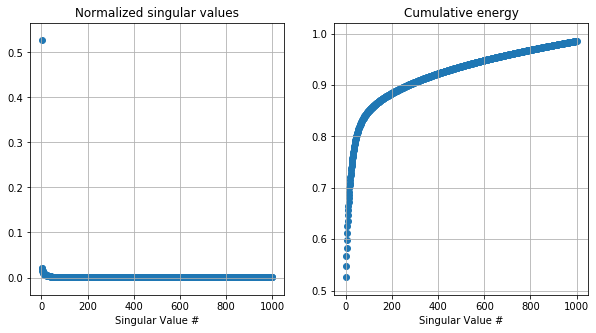

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.grid()
ax1.set_title('Normalized singular values')
ax1.set_xlabel('Singular Value #')
ax1.scatter(range(1, 1001), S_norm[0:1000])

ax2.grid()
ax2.set_title('Cumulative energy')
ax2.set_xlabel('Singular Value #')
ax2.scatter(range(1, 1001), np.cumsum(S_norm)[0:1000])
plt.savefig('figs/BZ_svd.png')

In [5]:
# Rank truncation at r=10
r = 650
Ur = U[:, 0:r]
Sigmar = np.diag(S[0:r])
Vr = V[:, 0:r]

In [6]:
# Reconstruct the data via truncated SVD
X_r = Ur @ Sigmar @ Vr.T.conj()
Data_r_tensor = X_r.reshape((351, 451, -1), order='F')

vmin = Data_flat.flatten().min()
vmax = Data_flat.flatten().max()

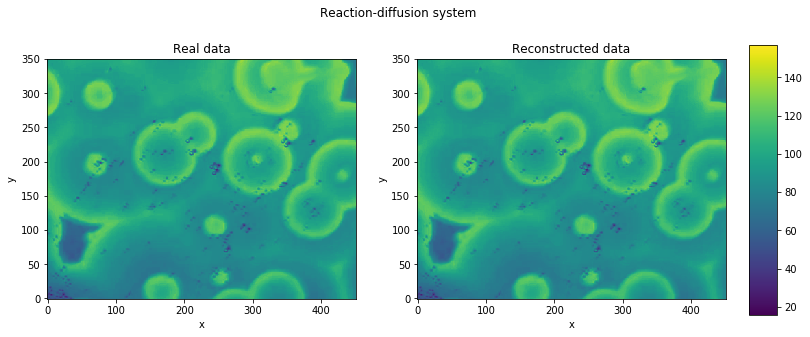

In [7]:
# Plot a comparison between the reconstructed data and the original data
# from IPython.display import HTML
# from matplotlib import rc

xx, yy = np.meshgrid(range(0, 351), range(0, 451))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Reaction-diffusion system')
map1 = ax1.imshow(Data_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax1.set_title('Real data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
map2 = ax2.imshow(Data_r_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax2.set_title('Reconstructed data')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.125, 0.03, 0.75])
fig.colorbar(map2, cax=cbar_ax)


# function to update figure
def updatefig(j):
    fig.get_axes()[0].get_images()[0].set_data(Data_tensor[:, :, j])
    fig.get_axes()[1].get_images()[0].set_data(Data_r_tensor[:, :, j])
    return fig

# Save the animation as an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim = animation.FuncAnimation(fig, updatefig, frames=range(Data_tensor.shape[2]-1), interval=0.1, blit=False)

anim.save('BZ_reconstruction.mp4', writer=writer)

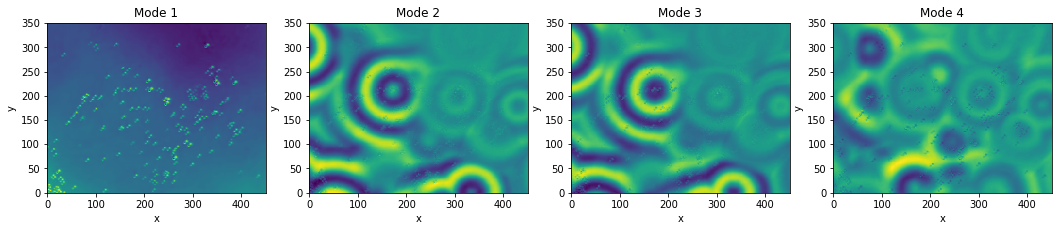

In [8]:
Modes_tensor = Ur[:, 0:4].reshape((351, 451, -1), order='F')
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for i in range(0, 4):
    mmap = axs[i].imshow(Modes_tensor[:, :, i], origin='lower')
    axs[i].set_title('Mode {}'.format(i+1))
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
plt.savefig('figs/BZ_modes.png')

In [9]:
# DMD
A_tilde = Ur.conj().T @ Xprime @ Vr @ np.linalg.inv(Sigmar)

Lambda, W = np.linalg.eig(A_tilde)
Phi = Xprime @ Vr @ np.linalg.inv(Sigmar) @ W
omega = np.log(Lambda) / dT
B = np.linalg.pinv(Phi) @ X[:, 0]

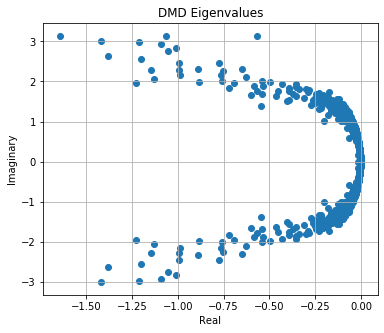

In [10]:
# Plot the eigenvalues
from sklearn.metrics import mean_squared_error

figx, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(np.real(omega), np.imag(omega))
ax.set_title('DMD Eigenvalues')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.grid()
plt.savefig('figs/BZ_DMD_eigenvalues.png')

In [11]:
# Compute and plot the MSE
t = np.linspace(0, dT * Data_tensor.shape[2], Data_tensor.shape[2]).reshape((1, -1))

Data_pred_flat = np.zeros((Data_flat.shape[0] ,t.shape[1]))

In [12]:
for k in range(0, r):
    Phi_k = Phi[:, k].reshape((Data_flat.shape[0], 1))
    Data_pred_flat += np.real(Phi_k @ B[k].reshape(1, 1) @ np.exp(omega[k] * t))
    if k % 50 == 0:
        print('Processing mode {}/{}'.format(k, r))
        

Processing mode 0/650
Processing mode 10/650
Processing mode 20/650
Processing mode 30/650
Processing mode 40/650
Processing mode 50/650
Processing mode 60/650
Processing mode 70/650
Processing mode 80/650
Processing mode 90/650
Processing mode 100/650
Processing mode 110/650
Processing mode 120/650
Processing mode 130/650
Processing mode 140/650
Processing mode 150/650
Processing mode 160/650
Processing mode 170/650
Processing mode 180/650
Processing mode 190/650
Processing mode 200/650
Processing mode 210/650
Processing mode 220/650
Processing mode 230/650
Processing mode 240/650
Processing mode 250/650
Processing mode 260/650
Processing mode 270/650
Processing mode 280/650
Processing mode 290/650
Processing mode 300/650
Processing mode 310/650
Processing mode 320/650
Processing mode 330/650
Processing mode 340/650
Processing mode 350/650
Processing mode 360/650
Processing mode 370/650
Processing mode 380/650
Processing mode 390/650
Processing mode 400/650
Processing mode 410/650
Pro

In [20]:
MSE_flat = np.sqrt(np.square(Data_flat - Data_pred_flat).mean(axis=0))

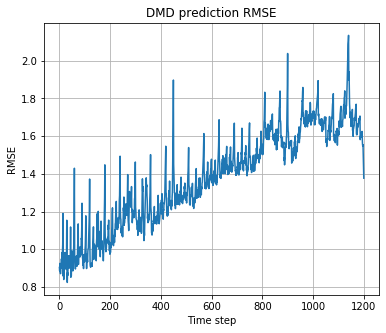

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(t.flatten(), MSE_flat)
ax.set_xlabel('Time step')
ax.set_ylabel('RMSE')
ax.set_title('DMD prediction RMSE')
ax.grid()
plt.savefig('figs/BZ_DMD_RMSE.png')

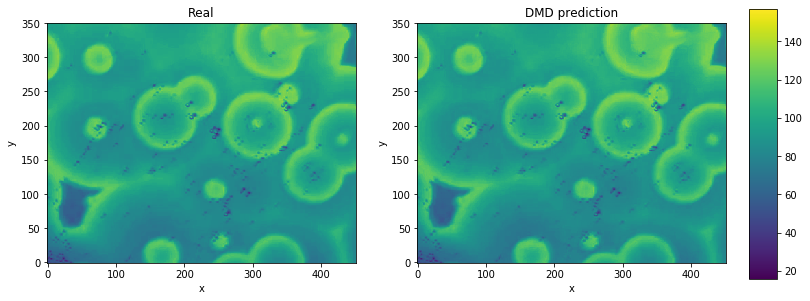

In [15]:
Data_predicted_tensor = Data_pred_flat.reshape((351, 451, -1), order='F')

xx, yy = np.meshgrid(range(0, 351), range(0, 451))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
map1 = ax1.imshow(Data_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax1.set_title('Real')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
map2 = ax2.imshow(Data_predicted_tensor[:, :, 0], vmin=vmin, vmax=vmax, origin='lower')
ax2.set_title('DMD prediction')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.125, 0.03, 0.75])
fig.colorbar(map2, cax=cbar_ax)


# function to update figure
def updatefig2(j):
    fig.get_axes()[0].get_images()[0].set_data(Data_tensor[:, :, j])
    fig.get_axes()[1].get_images()[0].set_data(Data_predicted_tensor[:, :, j])
    return fig

In [16]:
# Save the animation as an MP4 file
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim2 = animation.FuncAnimation(fig, updatefig2, frames=range(Data_tensor.shape[2]-1), interval=0.3, blit=False)

anim2.save('BZ_DMD_prediction.mp4', writer=writer)


Assume to measure only a limited amount of states (nu << n). 
We want to design a NN able to retrieve the coefficients of the SVD modes out of these limited amount of measurements.
Then based on these coefficient, the full state-space can be estimated by projection.


In [17]:
# Sampling matrix H with nu measurements only in random positions
import random 
nu = 50
_idx = random.sample(range(0, Data_flat.shape[0]), nu)
H = np.zeros((nu, Data_flat.shape[0]))
H[:, _idx] = 1

train_max = round(0.8 * Data_flat.shape[1])
Data_flat_lowrank = Ur.T.conj() @ Data_flat
Data_flat_train = Data_flat_lowrank[:, :train_max]
Data_flat_val = Data_flat_lowrank[:, train_max:]

norm_mean = np.mean(Data_flat_train, axis=1).reshape((-1, 1))
norm_std = np.std(Data_flat_train, axis=1).reshape((-1, 1))
Data_train_norm = (Data_flat_train - norm_mean) / norm_std
Data_val_norm = (Data_flat_val - norm_mean) / norm_std

In [18]:
# Construct the training and validation data-sets
X_train = (H @ Ur) @ Data_train_norm
Y_train = Data_train_norm
X_val = (H @ Ur) @ Data_val_norm
Y_val = Data_val_norm

In [22]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Add
from tensorflow.keras.callbacks import EarlyStopping
import os.path
from os.path import isfile, isdir

In [24]:
tf.enable_eager_execution()

# If a pre-trained network is available, load it
if isfile('saved/trained_network_part4') or isdir('saved/trained_network_part4'):
    nn = tf.keras.models.load_model('saved/trained_network_part4')
    print('Pre-trained NN model imported')

# otherwise, train a neural network from scratch
else:
    # To manually stop the training, put a file named STOP.txt in the main directory
    class CatchUserInterruptCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if isfile('STOP.txt'):
                print('Stopping on user request...')
                self.stopped_epoch = epoch
                self.model.stop_training = True
                os.remove('STOP.txt')

    # Shallow decoder structure
    x0 = Input(shape=(X_train.shape[0],))
    x1 = Dense(units=64, activation='tanh')(x0)
    x2 = LeakyReLU(alpha=0.1)(Dense(units=48)(x1))
    x3 = Dense(units=256, activation='tanh')(x2)
    x4 = Dense(units=512, activation='tanh')(x3)
    x5 = Dense(units=Y_train.shape[0], activation='tanh')(x4)

    nn = Model(x0, x5)
    nn.compile(tf.keras.optimizers.Adam(1e-3), loss='mse')

    # Early stopping rule based on validation loss
    esr = EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True, patience=400)
    nn.summary()
    nn.fit(X_train.T, Y_train.T, validation_data=(X_val.T, Y_val.T),
           epochs=5000, batch_size=64, shuffle=True, callbacks=[CatchUserInterruptCallback(), esr])

    nn.save('saved/trained_network_part4')
    print("Neural network trained and dumped to file")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                3120      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               12544     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 650)               333450